In [12]:
import torch
import seaborn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib          import Path
from torch.utils.data import TensorDataset, DataLoader
#
### Import local libraries
#
from model import NeuralNetwork
from model import batches

In [5]:
#
### Create a dataframe or load it from file
#
dataframe = pd.DataFrame({"I1": [],
                          "I2": [],
                          "I3": [],
                          "I4": [],
                          "X": [],
                          "Y": []})

data = np.load("../Data/test_data_LD7_tetra_dense_04232024.npy")
network_file = "neural_network.pth"

for i in range(4):
    mean = np.mean(data[i])
    std  = np.std(data[i])
    data[i] = (data[i] - mean) / std

for x in range(67):
    for y in range(67):
        new_point = pd.DataFrame({"I1": data[0, y, x], 
                          "I2": data[1, y, x], 
                          "I3": data[2, y, x], 
                          "I4": data[3, y, x], 
                          "X": (x - 33)/2, 
                          "Y": (y - 33)/2}, index=[0])
        dataframe = pd.concat([dataframe, new_point])
        
#
### Split data into 90% training and 10% testing
#
test_split = 20

limit = test_split*len(dataframe)//100
#
### Save full dataset in order
#
X_total   = torch.tensor( dataframe[["I1", "I2", "I3", "I4"]].values.tolist() )
Y_total   = torch.tensor( dataframe[["X", "Y"]].values.tolist() )
total_set = TensorDataset(X_total, Y_total)
total     = DataLoader(total_set, shuffle=False, batch_size=len(X_total))
#
### Shuffle the elements in the dataframe using a random state for reproducibility
#
dataframe = dataframe.sample(frac=1.0, random_state=123456)
#
### Create tensors for training data
#
X_train   = torch.tensor( dataframe[["I1", "I2", "I3", "I4"]].iloc[:-limit].values.tolist() )
Y_train   = torch.tensor( dataframe[["X", "Y"]].iloc[:-limit].values.tolist() )
#
### Create tensors for testing data
#
X_test    = torch.tensor( dataframe[["I1", "I2", "I3", "I4"]].iloc[-limit:].values.tolist() )
Y_test    = torch.tensor( dataframe[["X", "Y"]].iloc[-limit:].values.tolist() )
#
### Prepare training and testing sets for batching
#
train_set = TensorDataset(X_train, Y_train)
test_set  = TensorDataset(X_test,  Y_test)
#
### Load training and testing sets as batches
#
batch_size   = 187 # 1, 5, 25, 37, 187, 925

training  = DataLoader(train_set, shuffle=True, batch_size=batch_size)
testing   = DataLoader(test_set, shuffle=False, batch_size=batch_size)
#
### Loop must be divided into X (G1,G2,G3) and y (Temperature)
#
# for features, temperature in training: print(f'training: {features = }, {temperature = }')
# for features, temperature in testing:  print(f'testing:  {features = }, {temperature = }')

In [6]:
#
### Training parameters
#
learning_rate = 1e-2
weight_decay = 1e-4

epochs       = 10000
batch_size   = 187 # 1, 5, 25, 37, 187, 925
test_epoch   = 1000
#
### Define neural network
#
hidden_nf = 150
network = NeuralNetwork(hidden_nf=hidden_nf)
#
### Optimizer and Loss
#
optimizer = torch.optim.Adam(params=network.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss(reduction='sum')
#
### Scheduler
#
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 80], gamma=0.9)

1,train,6956.9838
2,train,3895.1605
3,train,3204.4789
4,train,2288.0975
5,train,1622.4818
6,train,1307.7991
7,train,1169.3236
8,train,1114.0526
9,train,1083.2406
10,train,994.7732
11,train,951.7132
12,train,927.4451
13,train,914.7719
14,train,917.6012
15,train,941.3737
16,train,847.3518
17,train,819.2836
18,train,804.7325
19,train,814.1155
20,train,831.0329
21,train,794.4172
22,train,760.6984
23,train,774.5809
24,train,750.3057
25,train,747.4299
26,train,722.2956
27,train,707.0691
28,train,718.7588
29,train,682.5287
30,train,653.8023
31,train,667.4401
32,train,635.4288
33,train,645.4293
34,train,636.5021
35,train,624.0630
36,train,623.8970
37,train,592.3216
38,train,579.5627
39,train,589.4062
40,train,571.4086
41,train,564.7659
42,train,633.1517
43,train,633.5106
44,train,654.1285
45,train,569.3908
46,train,568.2548
47,train,547.0625
48,train,534.5263
49,train,521.3004
50,train,512.0910
51,train,527.2122
52,train,540.2868
53,train,537.5696
54,train,526.9323
55,train,505.1595
56,train,5

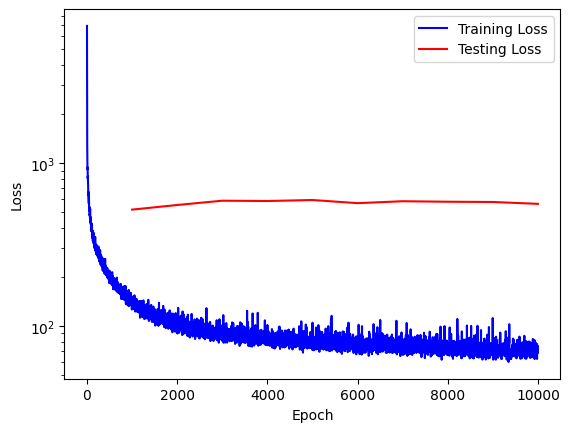

In [7]:
training_loss = []
testing_loss = []
testing_axis = range(test_epoch, epochs + 1, test_epoch)
for epoch in range(epochs):

        output, loss = batches(training, network=network, criterion=criterion, optimizer=optimizer, train=True)
        # scheduler.step()

        print(f'{epoch+1},train,{loss:.4f}')
        training_loss.append(loss)

        if (epoch+1)%test_epoch == 0:
            output, loss = batches(testing, network=network, criterion=criterion, optimizer=optimizer, train=False)

            print(f'{epoch+1},test,{loss:.4f}')
            testing_loss.append(loss)
            
torch.save(network.state_dict(), network_file)

loss_fig, loss_ax = plt.subplots()
loss_ax.plot(training_loss, label='Training Loss', color='b')
loss_ax.plot(testing_axis, testing_loss, label='Testing Loss', color='r')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
loss_ax.set_yscale('log')
loss_ax.legend()

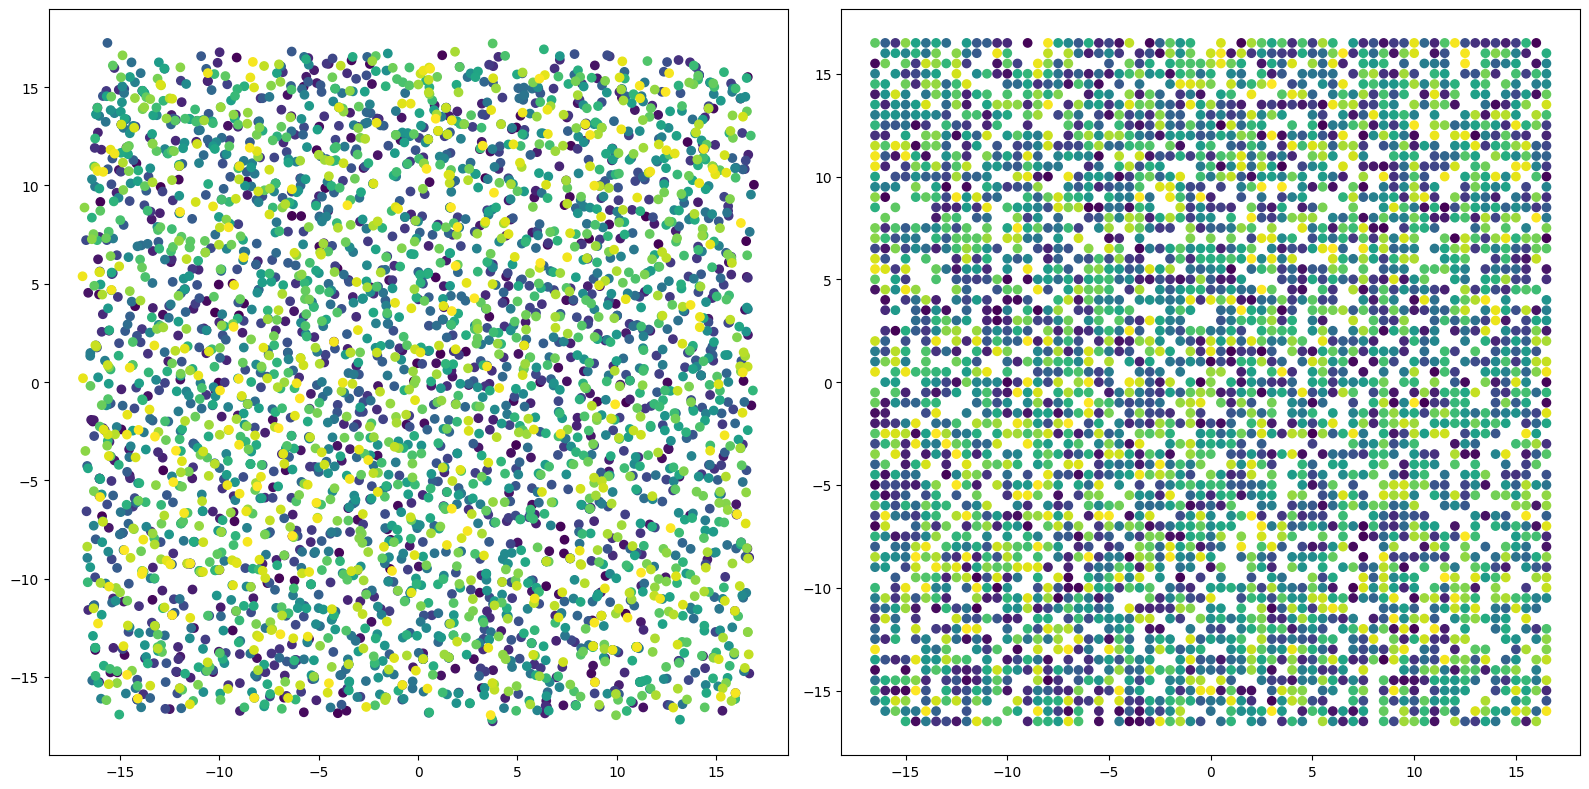

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), layout='tight')

training  = DataLoader(train_set, shuffle=False, batch_size=67*67)
testing   = DataLoader(test_set, shuffle=False, batch_size=67*67)

output, _ = batches(training, network=network, criterion=criterion, optimizer=optimizer, train=False)
# output = output.squeeze(0)

colors = range(0, len(X_train))
ax[0].scatter(output[:,0], output[:,1], c=colors, cmap='viridis')
ax[1].scatter(Y_train[:,0], Y_train[:,1], c=colors, cmap='viridis')

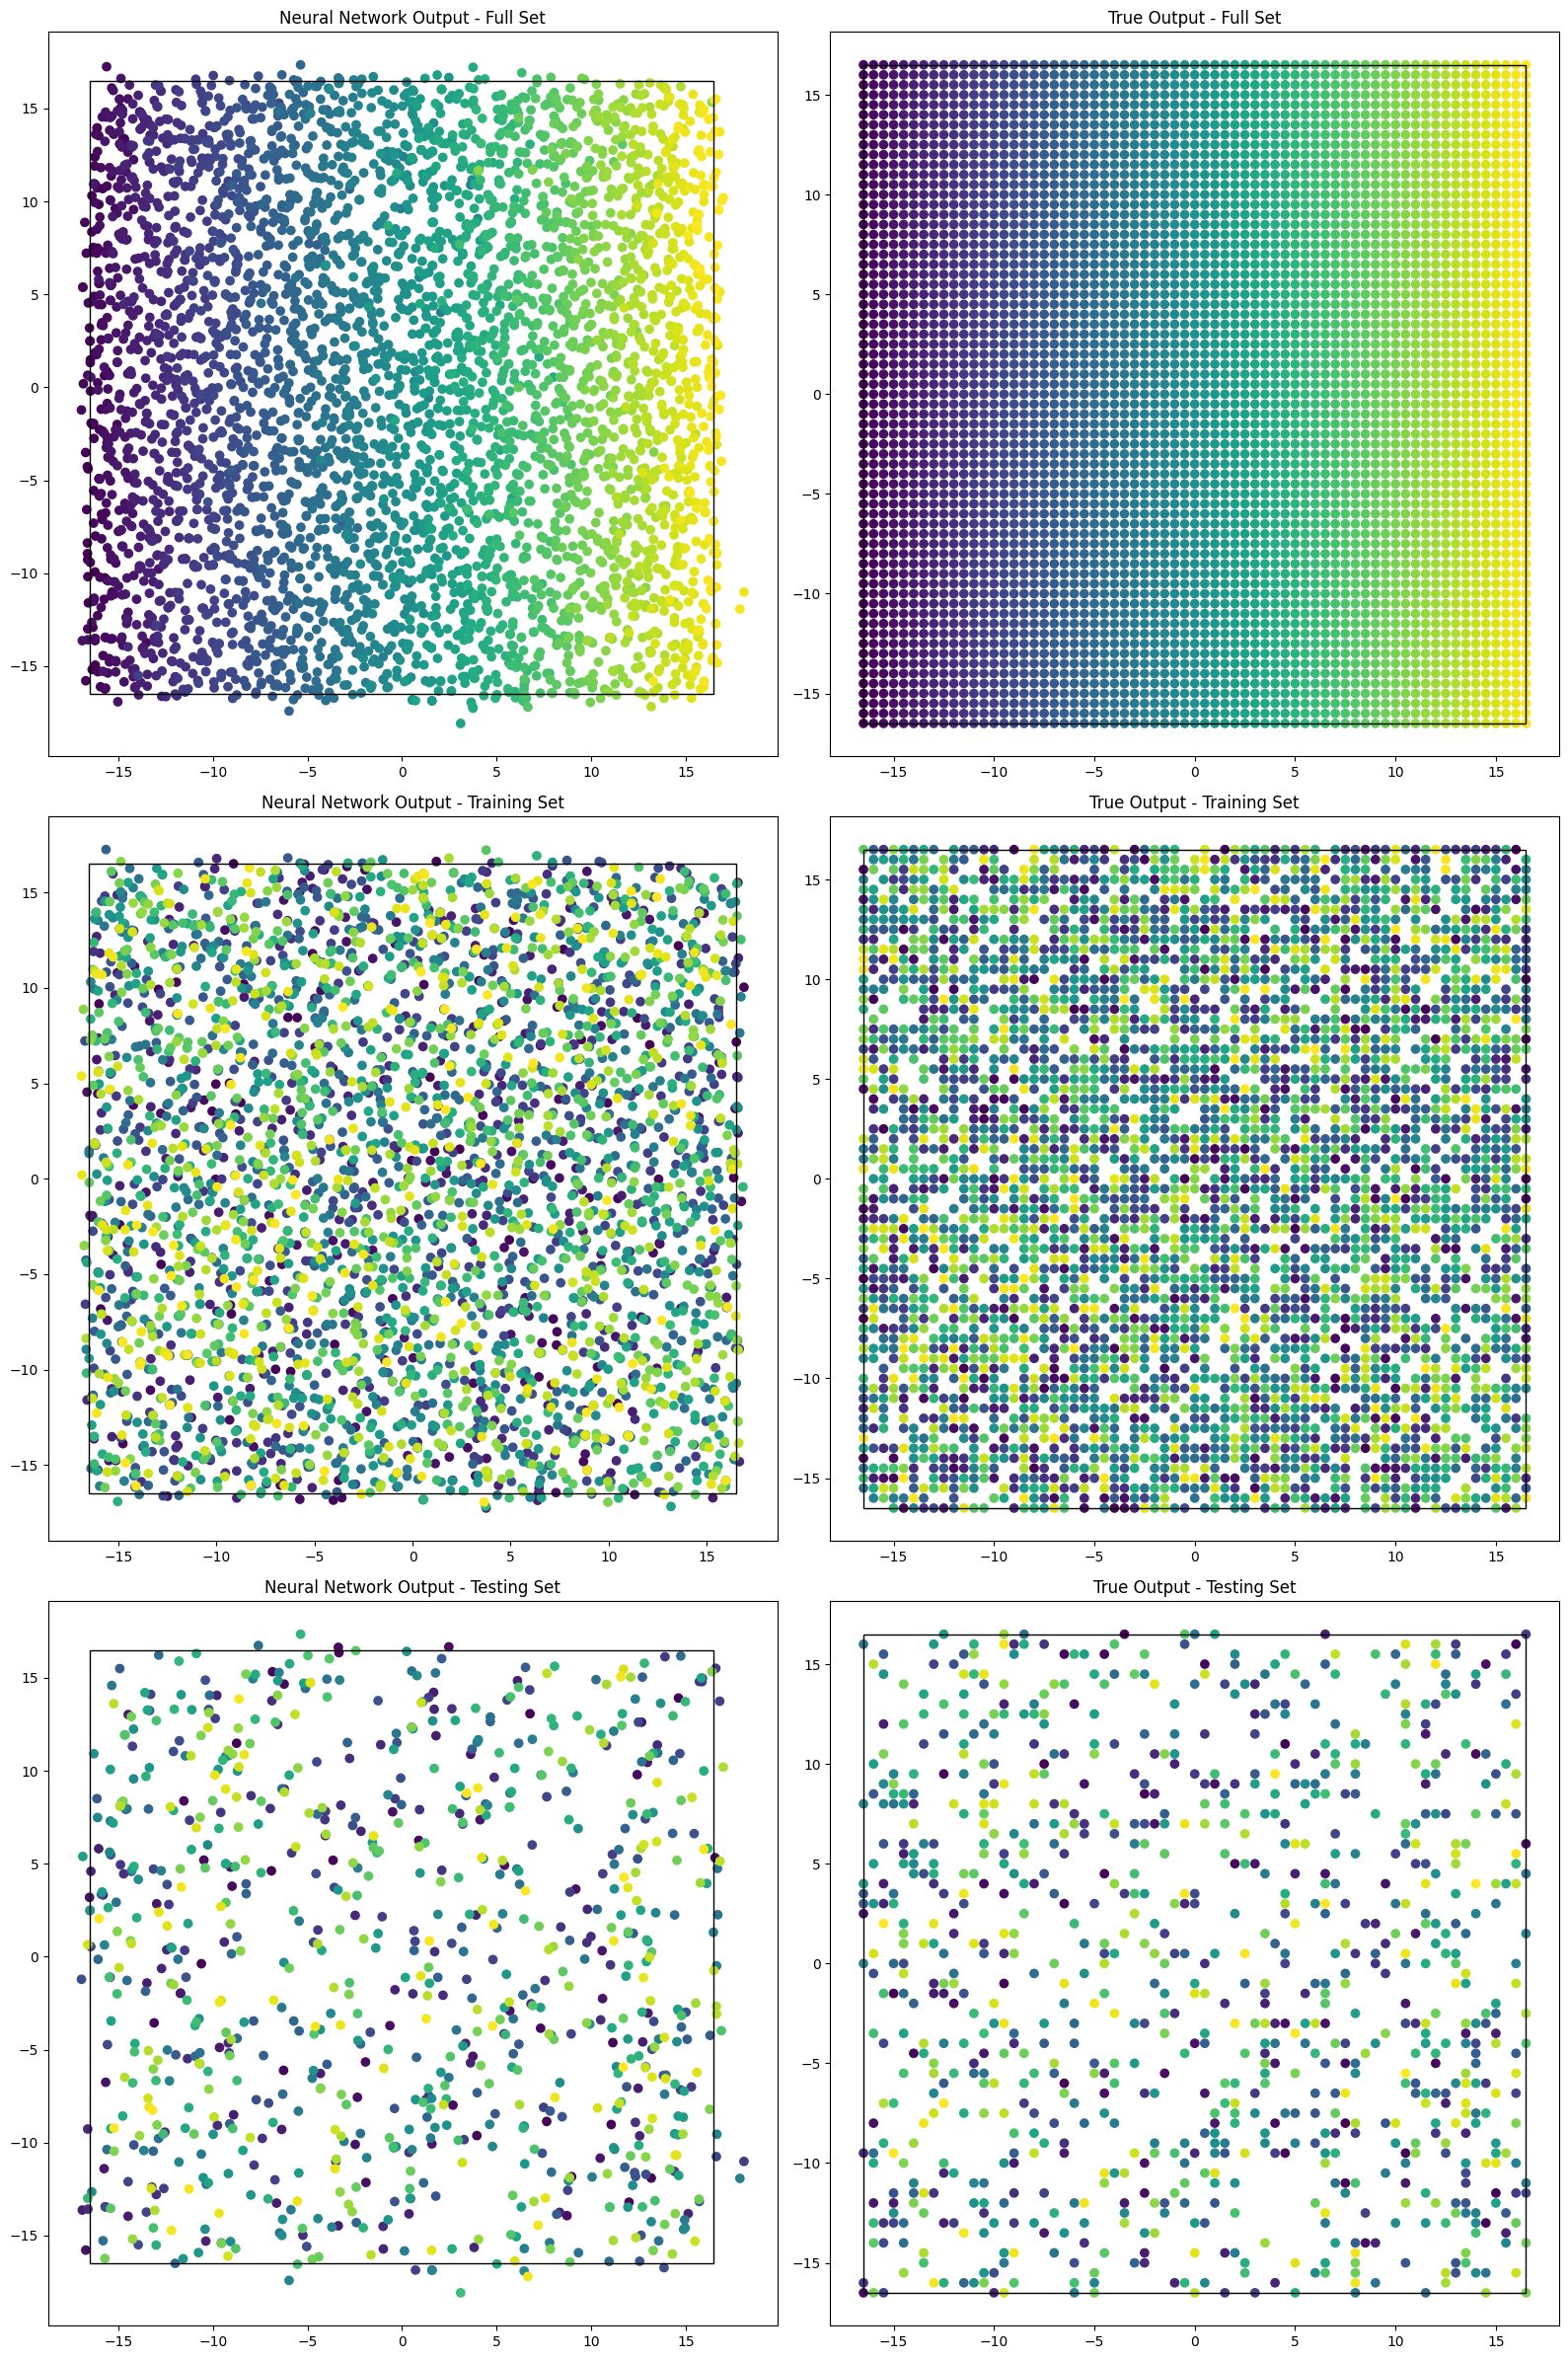

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,24), layout='tight')

output, _ = batches(total, network=network, criterion=criterion, optimizer=optimizer, train=False)
colors = range(0, len(X_total))
ax[0, 0].scatter(output[:,0], output[:,1], c=colors, cmap='viridis')
ax[0, 0].set_title("Neural Network Output - Full Set")
ax[0, 0].add_patch(patches.Rectangle((-33/2, -33/2), 33, 33, linewidth=1, edgecolor='k', facecolor='none'))
ax[0, 1].scatter(Y_total[:,0], Y_total[:,1], c=colors, cmap='viridis')
ax[0, 1].set_title("True Output - Full Set")
ax[0, 1].add_patch(patches.Rectangle((-33/2, -33/2), 33, 33, linewidth=1, edgecolor='k', facecolor='none'))

output, _ = batches(training, network=network, criterion=criterion, optimizer=optimizer, train=False)
colors = range(0, len(X_train))
ax[1, 0].scatter(output[:,0], output[:,1], c=colors, cmap='viridis')
ax[1, 0].set_title("Neural Network Output - Training Set")
ax[1, 0].add_patch(patches.Rectangle((-33/2, -33/2), 33, 33, linewidth=1, edgecolor='k', facecolor='none'))
ax[1, 1].scatter(Y_train[:,0], Y_train[:,1], c=colors, cmap='viridis')
ax[1, 1].set_title("True Output - Training Set")
ax[1, 1].add_patch(patches.Rectangle((-33/2, -33/2), 33, 33, linewidth=1, edgecolor='k', facecolor='none'))

output, _ = batches(testing, network=network, criterion=criterion, optimizer=optimizer, train=False)
colors = range(0, len(X_test))
ax[2, 0].scatter(output[:,0], output[:,1], c=colors, cmap='viridis')
ax[2, 0].set_title("Neural Network Output - Testing Set")
ax[2, 0].add_patch(patches.Rectangle((-33/2, -33/2), 33, 33, linewidth=1, edgecolor='k', facecolor='none'))
ax[2, 1].scatter(Y_test[:,0], Y_test[:,1], c=colors, cmap='viridis')
ax[2, 1].set_title("True Output - Testing Set")
ax[2, 1].add_patch(patches.Rectangle((-33/2, -33/2), 33, 33, linewidth=1, edgecolor='k', facecolor='none'))

plt.show()